# Machine Learning Assignment 2

# Part III: Implementing & Improving AlexNet

**1. Load, preprocess, analyze the dataset and make it ready for training. You can refer and reuse your code for Part I of this Assignment.**

**Importing required packages**

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import SVHN
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import sys
import numpy as np
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import os
from PIL import Image
from matplotlib.image import imread

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
torch.backends.mps.is_available()

True

#### Loading Dataset:

In [ ]:
cnn_dataset_path = '/Users/rohitambati/Desktop/Masters/Spring 2023/ML/Assignment 2/cnn_dataset'

**Visualization Graphs**

In [ ]:
# Count the number of images in each class
num_dog_images = len(os.listdir(os.path.join(cnn_dataset_path, 'dogs')))
num_food_images = len(os.listdir(os.path.join(cnn_dataset_path, 'food')))
num_vehicle_images = len(os.listdir(os.path.join(cnn_dataset_path, 'vehicles')))

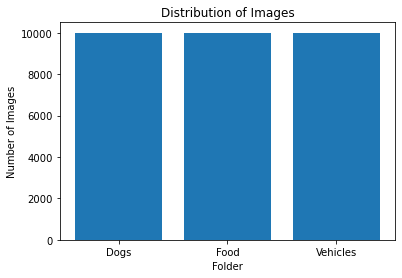

In [14]:
# Visualization graph 1: A bar chart showing the distribution of images across the three classes.
plt.bar(['Dogs', 'Food', 'Vehicles'], [num_dog_images, num_food_images, num_vehicle_images])
plt.title('Distribution of Images')
plt.xlabel('Folder')
plt.ylabel('Number of Images')
plt.show()

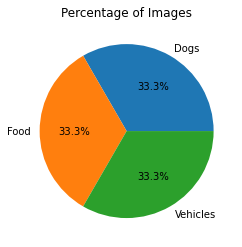

In [16]:
# Visualization graph 3: A pie chart showing the percentage of images in each class.
sizes = [num_dog_images, num_food_images, num_vehicle_images]
labels = ['Dogs', 'Food', 'Vehicles']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Images')
plt.show()

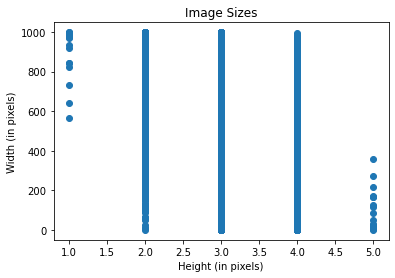

In [15]:
# Visualization graph 2: A scatter plot showing the distribution of image sizes in the dataset.
sizes = []
for folder in os.listdir(cnn_dataset_path):
    for file in os.listdir(os.path.join(cnn_dataset_path, folder)):
        sizes.append(os.path.getsize(os.path.join(cnn_dataset_path, folder, file)))

plt.scatter([s // 1000 for s in sizes], [s % 1000 for s in sizes])
plt.title('Image Sizes')
plt.xlabel('Height (in pixels)')
plt.ylabel('Width (in pixels)')
plt.show()

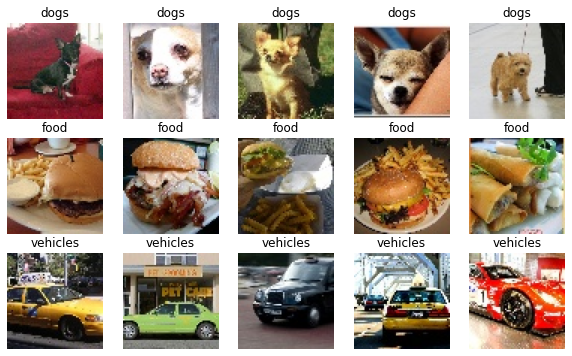

In [10]:
# Visualization graph 4: Displaying sample images from each class
folders = os.listdir(cnn_dataset_path)

fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i, folder in enumerate(folders):
    images = os.listdir(os.path.join(cnn_dataset_path, folder))[:5]
    for j, image in enumerate(images):
        img = cv2.imread(os.path.join(cnn_dataset_path, folder, image))
        axs[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i, j].set_title(folder)
        axs[i, j].axis('off')

plt.show()

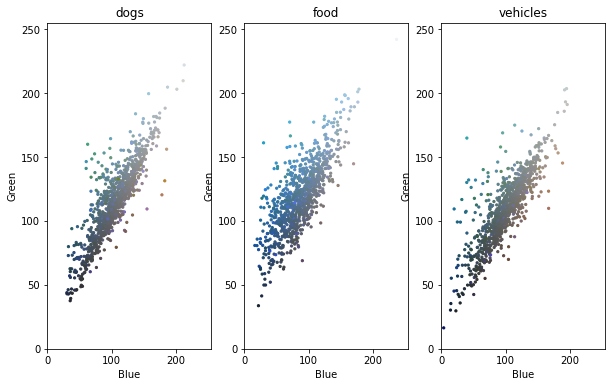

In [13]:
# Visualization graph 5: Image Color Distribution
folders = os.listdir(cnn_dataset_path)

fig, axs = plt.subplots(1, 3, figsize=(10, 6))

for i, folder in enumerate(folders):
    images = os.listdir(os.path.join(cnn_dataset_path, folder))[:1000]
    colors = []
    for image in images:
        img = cv2.imread(os.path.join(cnn_dataset_path, folder, image))
        colors.append(np.mean(img, axis=(0,1)))
        
    colors = np.array(colors)
    axs[i].scatter(colors[:,0], colors[:,1], s=5, c=colors/255)
    axs[i].set_title(folder)
    axs[i].set_xlabel('Blue')
    axs[i].set_ylabel('Green')
    axs[i].set_xlim([0, 255])
    axs[i].set_ylim([0, 255])
    
plt.show()

#### Data augmentation parameters:

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

In [ ]:
images = datasets.ImageFolder(cnn_dataset_path, transform = transform)

#### Train, Test, Validation Split:

In [ ]:
no_of_images = len(images)

# Define the sizes of each set
train_size = int(0.8 * no_of_images)  # 80% of the dataset for training
test_size = int(0.1 * no_of_images)  # 10% of the dataset for testing
val_size = no_of_images - train_size - test_size  # Remaining 10% for validation

# Use random_split to split the dataset into train, test, and validation sets
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(images, [train_size, test_size, val_size])

# Print the sizes of each set
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

Training set size: 24000
Testing set size: 3000
Validation set size: 3000


**2. Build and train an AlexNet CNN architecture (paper). For your dataset, adjust the size, e.g. for the input and the output layers.**

**Definiing AlexNet:**

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 3):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
num_epochs = 15
batch_size = 32
learning_rate = 0.005

cnn_model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr = learning_rate, momentum = 0.9)

total_step = len(train_dataset)

#### 3. Train the network and evaluate the performance of the AlexNet on the testing data.

**Calculating Training Accuracy**

In [ ]:
from tqdm import tqdm

In [ ]:
total_step = len(train_loader)
training_accuracy = []
test_accuracy = []
for epoch in range(num_epochs):
    
    epoch_acc = 0
    
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        
        #Calculating accuracy
        temp_output = []
        for j in outputs:
            max_value = j[0]
            index = 0
            for k in range(0,j.shape[0]):
                if(j[k] > max_value):
                    max_value = j[k]
                    index = k
            temp_output.append(index)
        acc = 0
        for j in range(len(temp_output)):
            if(labels[j].item() == temp_output[j]):
                acc = acc+1
            
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_acc += acc
        
        progress = (i+1)/len(train_loader)
        print(f"Progress: {progress*100:.2f}%", end="\r")
    
    training_accuracy.append(epoch_acc/(len(train_loader)*images.shape[0]))    
    print('Epoch [{}/{}], Step [{}/{}], Train Accuracy: {}, ' 
                   .format(epoch+1, num_epochs, i+1, total_step, epoch_acc/(len(train_loader)*images.shape[0])), end = "")
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        print('Test Accuracy: {}'.format(correct / total))  
        
        test_accuracy.append(correct / total)

   

Epoch [1/15], Step [750/750], Train Accuracy: 0.601125, Test Accuracy: 0.7833333333333333
Epoch [2/15], Step [750/750], Train Accuracy: 0.7839583333333333, Test Accuracy: 0.771
Epoch [3/15], Step [750/750], Train Accuracy: 0.82725, Test Accuracy: 0.8416666666666667
Epoch [4/15], Step [750/750], Train Accuracy: 0.8572916666666667, Test Accuracy: 0.81
Epoch [5/15], Step [750/750], Train Accuracy: 0.8813333333333333, Test Accuracy: 0.8803333333333333
Epoch [6/15], Step [750/750], Train Accuracy: 0.8962916666666667, Test Accuracy: 0.8593333333333333
Epoch [7/15], Step [750/750], Train Accuracy: 0.902875, Test Accuracy: 0.8923333333333333
Epoch [8/15], Step [750/750], Train Accuracy: 0.9159166666666667, Test Accuracy: 0.8976666666666666
Epoch [9/15], Step [750/750], Train Accuracy: 0.925875, Test Accuracy: 0.9073333333333333
Epoch [10/15], Step [750/750], Train Accuracy: 0.9325833333333333, Test Accuracy: 0.9156666666666666
Epoch [11/15], Step [750/750], Train Accuracy: 0.9380833333333334, 

**Plotting training accuracy and testing accuracy**

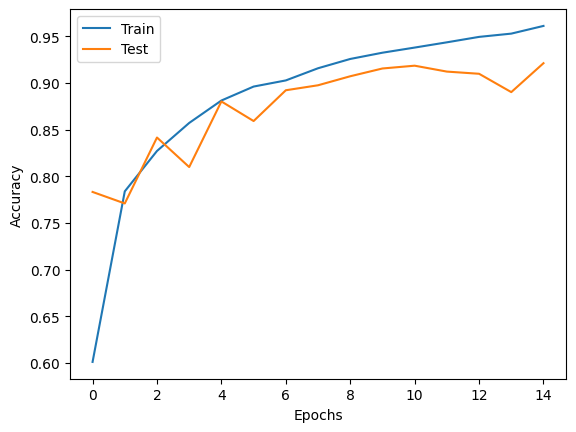

In [ ]:
plt.plot(training_accuracy, label = 'Train')
plt.plot(test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### 4. Modify AlexNet structure (e.g. add/remove layers, update the kernel size, adjust the hyperparameters), add improvement methods that you tried for “Part II - Step 3” of this assignment, that are applicable to CNN architecture (e.g. earlystopping).

**Modified AlexNet Structure**

In [ ]:
class AlexNetModified(nn.Module):
    def __init__(self, num_classes = 3):
        super(AlexNetModified, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
num_epochs = 15
learning_rate = 0.005
mod_cnn_model = AlexNetModified().to(device)
criterion = nn.CrossEntropyLoss()
mod_optimizer = torch.optim.SGD(mod_cnn_model.parameters(), lr = learning_rate, momentum = 0.9)

In [ ]:
total_step = len(train_loader)
mod_training_accuracy = []

n_epochs_stop = 5
min_val_loss = np.Inf
epochs_no_improve = 0
final_val_loss = 0

**Calculating Training Accuracy**

In [ ]:
total_step = len(train_loader)
training_accuracy = []
test_accuracy = []
validation_accuracy = [] 

for epoch in range(num_epochs):
    epoch_acc = 0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = mod_cnn_model(images)
        #print(outputs.dtype)
        loss = criterion(outputs, labels)
        
        #Calculating accuracy
        temp_output = []
        for j in outputs:
            max_value = j[0]
            index = 0
            for k in range(0,j.shape[0]):
                if(j[k] > max_value):
                    max_value = j[k]
                    index = k
            temp_output.append(index)
        #print(temp_output[0],outputs[0])
        acc = 0
        for j in range(len(temp_output)):
            if(labels[j].item() == temp_output[j]):
                acc = acc+1
            
        # Backward and optimize
        mod_optimizer.zero_grad()
        loss.backward()
        mod_optimizer.step()
        
        epoch_acc += acc
        #print(acc)
        
        progress = (i+1)/len(train_loader)
        print(f"Progress: {progress*100:.2f}%", end="\r")
        
    training_accuracy.append(epoch_acc/(len(train_loader)*images.shape[0]))    
    print (f'| Epoch [{epoch+1}/{num_epochs}] | Train Accuracy: {epoch_acc/(len(train_loader)*images.shape[0]):.5f} ', end = "")
    
    #Testing
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = mod_cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        print(f'| Test Accuracy: {correct / total:.5f} ', end = "")  
        test_accuracy.append(correct / total)

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = mod_cnn_model(images)
            val_loss = criterion(outputs, labels)
            final_val_loss += val_loss
            # Average validation loss
            final_val_loss = final_val_loss/len(val_loader)
            
             # If the validation loss is at a minimum
            if final_val_loss < min_val_loss:
                epochs_no_improve = 0
                min_val_loss = final_val_loss

            else:
                #print("final_val_loss:", final_val_loss, "min_val_loss:", min_val_loss)
                epochs_no_improve += 1
                # Check early stopping condition
                if epochs_no_improve == n_epochs_stop:
                    print('Early stopping!')
                    break

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        print(f'| Validation Accuracy: {correct / total:.5f} |')
        validation_accuracy.append(100 * correct / total)

| Epoch [1/15] | Train Accuracy: 0.82567 | Test Accuracy: 0.85933 | Validation Accuracy: 0.87067 |
| Epoch [2/15] | Train Accuracy: 0.88271 | Test Accuracy: 0.88800 | Validation Accuracy: 0.90000 |
| Epoch [3/15] | Train Accuracy: 0.90371 | Test Accuracy: 0.89833 | Validation Accuracy: 0.89567 |
| Epoch [4/15] | Train Accuracy: 0.91612 | Test Accuracy: 0.90033 | Validation Accuracy: 0.91233 |
| Epoch [5/15] | Train Accuracy: 0.92521 | Test Accuracy: 0.89700 | Validation Accuracy: 0.91333 |
| Epoch [6/15] | Train Accuracy: 0.93592 | Test Accuracy: 0.91400 | Validation Accuracy: 0.92700 |
| Epoch [7/15] | Train Accuracy: 0.94150 | Test Accuracy: 0.92100 | Validation Accuracy: 0.93033 |
| Epoch [8/15] | Train Accuracy: 0.94625 | Test Accuracy: 0.91967 | Validation Accuracy: 0.92600 |
| Epoch [9/15] | Train Accuracy: 0.95088 | Test Accuracy: 0.92500 | Validation Accuracy: 0.93033 |
| Epoch [10/15] | Train Accuracy: 0.95500 | Test Accuracy: 0.92833 | Validation Accuracy: 0.93467 |
| Epoch [

**Plotting testing and training accuracy**

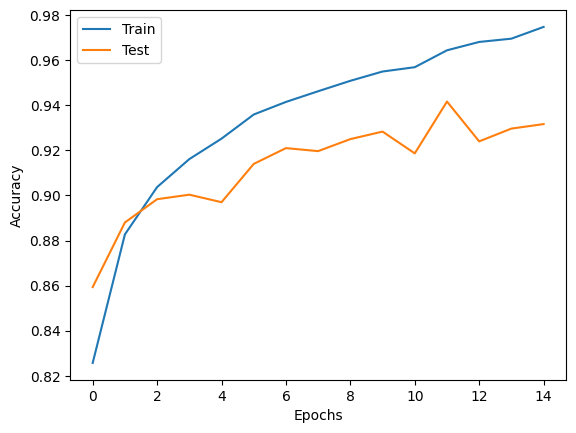

In [ ]:
plt.plot(training_accuracy, label = 'Train')
plt.plot(test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Part IV: Optimizing CNN + Data Argumentation

#### Importing libraries:

In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomAffine, ToTensor, Normalize
import torch.nn as nn
import torch.optim as optim
import copy
from tqdm import tqdm
import torchvision.utils as vutils
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

### STEPS: 

#### 1. Load, preprocess, analyze the dataset and make it ready for training. You can refer and reuse your code for Part I of this Assignment.

In [3]:
# Define data transforms
training_transforms_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

testing_transforms_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

aug_training_transforms_svhn = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue = 0.1),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Define datasets and data loaders
training_dataset_svhn = SVHN(root='./data', split='train', transform=training_transforms_svhn, download=True)
aug_training_dataset_svhn = SVHN(root='./data', split='train', transform=aug_training_transforms_svhn, download=True)
testing_dataset_svhn = SVHN(root='./data', split='test', transform=testing_transforms_svhn, download=True)

100%|██████████| 182040794/182040794 [00:03<00:00, 59620781.33it/s]


Using downloaded and verified file: ./data/train_32x32.mat


100%|██████████| 64275384/64275384 [00:01<00:00, 55778352.73it/s]


In [5]:
# Printing testing and training sets
print(f"Training set: {len(training_dataset_svhn)} images")
print(f"Testing set: {len(testing_dataset_svhn)} images")
print(f"Image size: {training_dataset_svhn[0][0].shape}")

print(f"Aug Training set: {len(aug_training_dataset_svhn)} images")
print(f"Image size: {aug_training_dataset_svhn[0][0].shape}")

Training set: 73257 images
Testing set: 26032 images
Image size: torch.Size([3, 32, 32])
Aug Training set: 73257 images
Image size: torch.Size([3, 32, 32])


**Data Visualizations**

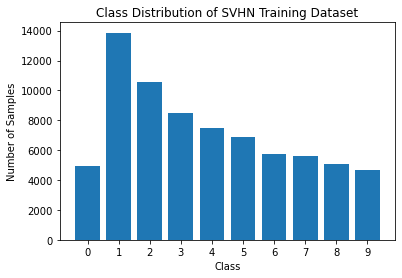

In [9]:
# Visualization graph 1: Class distribution bar chart
class_counts = [training_dataset_svhn.labels.tolist().count(i) for i in range(10)]
class_names = [str(i) for i in range(10)]

plt.bar(class_names, class_counts)
plt.title("Class Distribution of SVHN Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

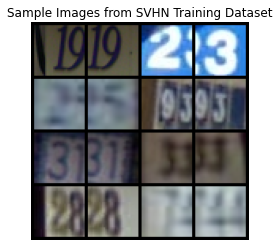

In [11]:
# Visualization graph 2: Creating a grid of sample images from the SVHN training dataset to get a visual understanding of the data.
sample_images = [training_dataset_svhn[i][0] for i in range(16)]
sample_grid = vutils.make_grid(sample_images, nrow=4, padding=2, normalize=True)

plt.imshow(sample_grid.permute(1, 2, 0))
plt.title("Sample Images from SVHN Training Dataset")
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


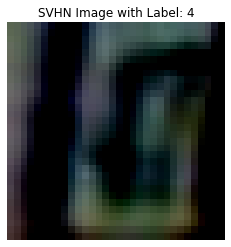

In [18]:
# Visualization graph 3: Image with Label
index = random.randint(0, len(training_dataset_svhn))
image, label = training_dataset_svhn[index]

plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.title(f'SVHN Image with Label: {label}')
plt.show()

Using downloaded and verified file: ./data\train_32x32.mat


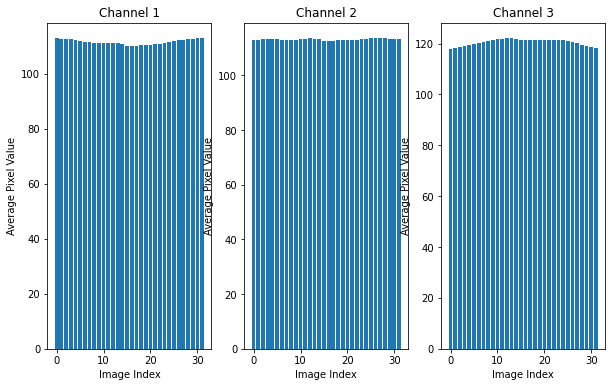

In [20]:
# Visualization graph 4: This plot shows the average pixel values for each channel (red, green, and blue) in the SVHN dataset.
train_set = SVHN(root='./data', split='train', download=True)
images = train_set.data.transpose(0, 2, 3, 1)

fig, axs = plt.subplots(1, 3, figsize=(10, 6))

for i in range(3):
    channel_vals = images[:,:,:,i].flatten()
    colors = [np.mean(channel_vals[j::32]) for j in range(32)]
    axs[i].bar(range(32), colors)
    axs[i].set_title('Channel {}'.format(i+1))
    axs[i].set_xlabel('Image Index')
    axs[i].set_ylabel('Average Pixel Value')

plt.show()

#### 2. Use your CNN architecture from Part III as a base version and adjust it for SVHN task.

In [7]:
class AlexNetSVHN(nn.Module):
    def __init__(self, num_classes = 10):
        super(AlexNetSVHN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=1),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 5, stride = 1)
          )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=5, stride=1, padding=1),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=5, stride=1, padding=1),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=11, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 11, stride = 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer5(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

#### 3. Increase the dataset by x2 using any data augmentation techniques (rotations, shifting, mirroring, etc). You can refer to Keras documentation for more details. You can use a combination of these techniques simultaneously.

In [8]:
svhn_training_dataset = torch.utils.data.ConcatDataset([training_dataset_svhn, aug_training_dataset_svhn])

In [9]:
print(f"Augmented training set: {len(training_dataset_svhn)} images")
print(f"New training set size: {len(svhn_training_dataset)} images")

Augmented training set: 73257 images
New training set size: 146514 images


In [10]:
svhn_batch_size = 128
svhn_train_loader = torch.utils.data.DataLoader(svhn_training_dataset, batch_size = svhn_batch_size, shuffle=True)
svhn_test_loader = torch.utils.data.DataLoader(testing_dataset_svhn, batch_size = svhn_batch_size, shuffle=False)

#### 4. Train the network and evaluate the performance on the testing data.

In [11]:
num_epochs = 7
batch_size = 128
learning_rate = 0.005

svhn_cnn_model = AlexNetSVHN().to(device)
criterion = nn.CrossEntropyLoss()
svh_optimizer = torch.optim.SGD(svhn_cnn_model.parameters(), lr = learning_rate, momentum = 0.9)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [14]:
# Calculating training accuracy
total_steps = len(svhn_training_dataset)
num_epochs = 7
optimizer = torch.optim.SGD(svhn_cnn_model.parameters(), lr = 0.005, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

training_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(svhn_train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = svhn_cnn_model(images)
        #print(outputs.dtype)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        progress = (i+1)/len(svhn_train_loader)
        print(f"Progress: {progress*100:.2f}%", end="\r")

        
    #Calculating Train Accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in svhn_train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = svhn_cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
    training_accuracy.append(correct / total)
    print(f'| Epoch [{epoch+1}/{num_epochs}] | Train Accuracy: {correct / total:.5f} ', end = "") 
    
    #Calculating Test Accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in svhn_test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = svhn_cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
    test_accuracy.append(correct / total)
    print(f'| Test Accuracy: {correct / total:.5f} |') 

| Epoch [1/7] | Train Accuracy: 0.84476 | Test Accuracy: 0.87980 |
| Epoch [2/7] | Train Accuracy: 0.90505 | Test Accuracy: 0.92179 |
| Epoch [3/7] | Train Accuracy: 0.92340 | Test Accuracy: 0.93827 |
| Epoch [4/7] | Train Accuracy: 0.93324 | Test Accuracy: 0.93639 |
| Epoch [5/7] | Train Accuracy: 0.94143 | Test Accuracy: 0.93750 |
| Epoch [6/7] | Train Accuracy: 0.95019 | Test Accuracy: 0.94315 |
| Epoch [7/7] | Train Accuracy: 0.95348 | Test Accuracy: 0.94161 |


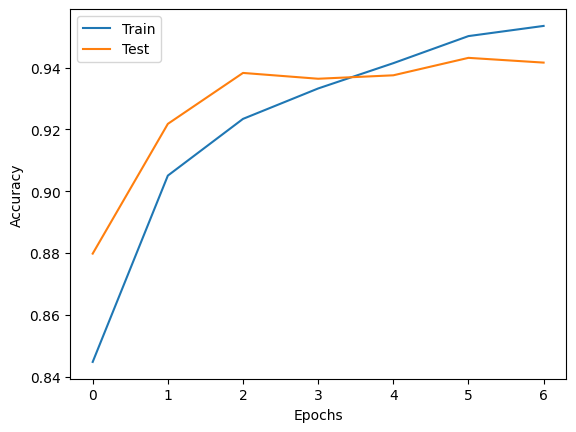

In [15]:
# Plotting training and testing accuracy graph
plt.plot(training_accuracy, label = 'Train')
plt.plot(test_accuracy, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

References:
1. https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/2
2. https://blog.paperspace.com/alexnet-pytorch/
3. https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
4. https://medium.com/@anqichen021/working-of-a-convolutional-neural-network-cnn-and-the-alexnet-architecture-d49ef158bcef
5. https://towardsdatascience.com/visualizing-and-preprocessing-image-dataset-e3ad574f7be6